In [1]:
# import packages
import pandas as pd
import re
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import os
import gzip
import argparse
from collections import defaultdict


#paths
# Edit these if your files are elsewhere:
p_23 = Path("23andme_v5_hg19_ref.txt.gz")
p_ann = Path("var_drug_ann.tsv")

### AI Disclaimer

*   **Question 1**: `.str.startswith("rs", na=False)` and also the .read_csv(Reference: [pandas.Series.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html))
*   **Question 2**: `open(p_ann, "r", encoding="utf-8", errors="replace")` and also the .read_csv in `low_memory=False`(Reference: [pandas.Series.read_csv](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html))
*   **Question 3**: `.str.fullmatch(r"rs\d+", na=False)`
*   **Question 4**: `.merge()` (Reference: [pandas.DataFrame.merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html))
*   **Question 5**: `.str.lower()` (Reference: [pandas.Series.str.lower](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.lower.html))
*   **Question 6**: `.to_csv()` (Reference: [pandas.DataFrame.to_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html))
*   **Question 7**: `.reset_index` (Reference: [pandas.DataFrame.reset_index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html))
*   **Question 8**: `.nunique()` (Reference: [pandas.DataFrame.nunique](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.nunique.html))

In [2]:
#(1.1) Load 23andMe file
p_23 = "23andme_v5_hg19_ref.txt"  # or the full path if needed

df_23 = pd.read_csv(
    p_23,
    sep="\t",
    header=0,        # first line has headers
    names=["CHR", "POS", "dbSNP_ID", "ALLELE"],  # enforce the correct order
    dtype=str,
)

# Drop rows missing rsIDs (some entries have i###### codes)
df_23 = df_23[df_23["dbSNP_ID"].str.startswith("rs", na=False)].copy()

# Rename to match project convention
df_23.rename(columns={"ALLELE": "ALLELE_23andme"}, inplace=True)

print(df_23.head())
print(df_23.shape)


    CHR     POS     dbSNP_ID ALLELE_23andme
0  chr1   74792   rs13328684              G
1  chr1  565508    rs9283150              G
3  chr1  727841  rs116587930              G
4  chr1  752721    rs3131972              A
5  chr1  754105   rs12184325              C
(620633, 4)


In [3]:
# (1.2) Load PharmGKB variant file
p_ann = "var_drug_ann.tsv"

# Skip the single bad line containing “The 15-year cumulative”
lines_clean = []
with open(p_ann, "r", encoding="utf-8", errors="replace") as f:
    for line in f:
        if "The 15-year cumulative" in line:
            continue
        lines_clean.append(line)

from io import StringIO
df_ann = pd.read_csv(StringIO("".join(lines_clean)), sep="\t", dtype=str, low_memory=False)

# (1.3) we select & rename relevant columns
col_map = {
    "Variant/Haplotypes": "dbSNP_ID",
    "Gene": "GENE_SYMBOL",
    "Drug(s)": "DRUG_NAME",
    "PMID": "PMID",
    "Phenotype Category": "PHENOTYPE_CATEGORY",
    "Significance": "SIGNIFICANCE",
    "Notes": "NOTES",
    "Sentence": "SENTENCE",
    "Alleles": "ALLELE_PharmGKB",
}

df_ann = df_ann[list(col_map.keys())].rename(columns=col_map)

# Keep only rows with valid rsIDs
df_ann = df_ann[df_ann["dbSNP_ID"].str.fullmatch(r"rs\d+", na=False)].copy()

print("PharmGKB loaded:", df_ann.shape)
print(df_ann.head())

PharmGKB loaded: (9817, 9)
     dbSNP_ID GENE_SYMBOL                                          DRUG_NAME  \
1   rs2909451        DPP4                                        sitagliptin   
2    rs706795       FAIM2  citalopram, escitalopram, fluoxetine, fluvoxam...   
3  rs16918842       OPRK1                                             heroin   
5   rs2285676      KCNJ11                                        sitagliptin   
7    rs163184       KCNQ1                                        sitagliptin   

       PMID PHENOTYPE_CATEGORY SIGNIFICANCE  \
1  39792745           Efficacy          yes   
2  40054571           Efficacy           no   
3  31940240             Dosage           no   
5  39792745           Efficacy          yes   
7  39792745           Efficacy          yes   

                                               NOTES  \
1  "Patients with the rs2909451 TT genotype in th...   
2  "We observed nominally significant association...   
3  No significant difference in allele or

In [4]:
# (1.4) we will merge with 23andMe
df_merge = df_ann.merge(df_23[["dbSNP_ID", "ALLELE_23andme"]], on="dbSNP_ID", how="inner")

df_merge = df_merge[
    ["dbSNP_ID", "GENE_SYMBOL", "DRUG_NAME", "PMID",
     "PHENOTYPE_CATEGORY", "SIGNIFICANCE", "NOTES", "SENTENCE",
     "ALLELE_PharmGKB", "ALLELE_23andme"]
]
print("Merged rows:", df_merge.shape)
df_merge.head()

Merged rows: (6111, 10)


,dbSNP_ID,GENE_SYMBOL,DRUG_NAME,PMID,PHENOTYPE_CATEGORY,SIGNIFICANCE,NOTES,SENTENCE,ALLELE_PharmGKB,ALLELE_23andme
0,rs706795,FAIM2,"citalopram, escitalopram, fluoxetine, fluvoxam...",40054571,Efficacy,no,"""We observed nominally significant association...",Allele T is associated with increased response...,T,T
1,rs16918842,OPRK1,heroin,31940240,Dosage,no,No significant difference in allele or genotyp...,Allele T is not associated with dose of heroin...,T,C
2,rs163184,KCNQ1,sitagliptin,39792745,Efficacy,yes,"""KCNQ1 gene polymorphisms also significantly a...",Genotype GG is associated with decreased respo...,GG,T
3,rs7754840,CDKAL1,sitagliptin,39792745,Efficacy,no,"""Patients with the rs7754840 CG genotype showe...",Genotype CG is associated with increased respo...,CG,G
4,rs1799853,CYP2C9,sitagliptin,39792745,Efficacy,yes,"""CYP2C9 gene polymorphisms also significantly ...",Genotype TT is associated with decreased respo...,TT,C


In [5]:
#(2)filter for significant efficacy variants
df_sig_eff = df_merge[
    (df_merge["SIGNIFICANCE"].str.lower() == "yes") &
    (df_merge["PHENOTYPE_CATEGORY"].str.lower() == "efficacy")
].copy()

print("Filtered (significant + efficacy):", df_sig_eff.shape)
df_sig_eff.head()

Filtered (significant + efficacy): (1434, 10)


,dbSNP_ID,GENE_SYMBOL,DRUG_NAME,PMID,PHENOTYPE_CATEGORY,SIGNIFICANCE,NOTES,SENTENCE,ALLELE_PharmGKB,ALLELE_23andme
2,rs163184,KCNQ1,sitagliptin,39792745,Efficacy,yes,"""KCNQ1 gene polymorphisms also significantly a...",Genotype GG is associated with decreased respo...,GG,T
4,rs1799853,CYP2C9,sitagliptin,39792745,Efficacy,yes,"""CYP2C9 gene polymorphisms also significantly ...",Genotype TT is associated with decreased respo...,TT,C
5,rs7903146,TCF7L2,exenatide,30700996,Efficacy,yes,"""After treatment with exenatide, only CT/TT in...",Genotypes CT + TT is associated with increased...,CT + TT,C
8,rs8099917,IFNL3,"peginterferon alfa-2a, peginterferon alfa-2b, ...",26075078,Efficacy,yes,A multivariate logistic model showed that the ...,Genotype TT is associated with increased respo...,TT,T
9,rs8099917,IFNL3,"peginterferon alfa-2b, ribavirin",22328925,Efficacy,yes,This genotype is associated with sustained vir...,Genotype TT is associated with increased respo...,TT,T


In [6]:
#(3) save 23andme_PharmGKB_map.tsv
cols_map = [
    "dbSNP_ID", "GENE_SYMBOL", "DRUG_NAME",
    "NOTES", "SENTENCE", "ALLELE_PharmGKB", "ALLELE_23andme"
]
df_sig_eff[cols_map].to_csv("23andme_PharmGKB_map.tsv", sep="\t", index=False)
print(" Saved 23andme_PharmGKB_map.tsv")

 Saved 23andme_PharmGKB_map.tsv


In [7]:
#(4) summarized file
# GENE_SYMBOL, DRUG_NAME, dbSNP_IDs (semicolon-separated)
summary = (
    df_sig_eff.groupby(["GENE_SYMBOL", "DRUG_NAME"])["dbSNP_ID"]
    .apply(lambda s: ";".join(sorted(set(s))))
    .reset_index(name="dbSNP_IDs")
)
summary.to_csv("23andme_PharmGKB_summary.tsv", sep="\t", index=False)
print("Saved 23andme_PharmGKB_summary.tsv")

Saved 23andme_PharmGKB_summary.tsv


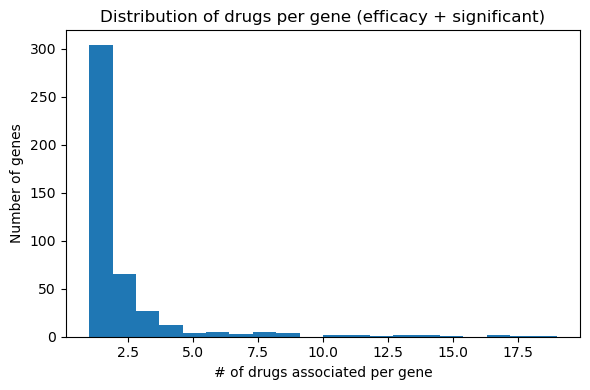

In [8]:
#(5) plot the histograms
# Number of drugs per gene
drugs_per_gene = df_sig_eff.groupby("GENE_SYMBOL")["DRUG_NAME"].nunique()
plt.figure(figsize=(6,4))
plt.hist(drugs_per_gene, bins=20)
plt.xlabel("# of drugs associated per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of drugs per gene (efficacy + significant)")
plt.tight_layout()
plt.show()

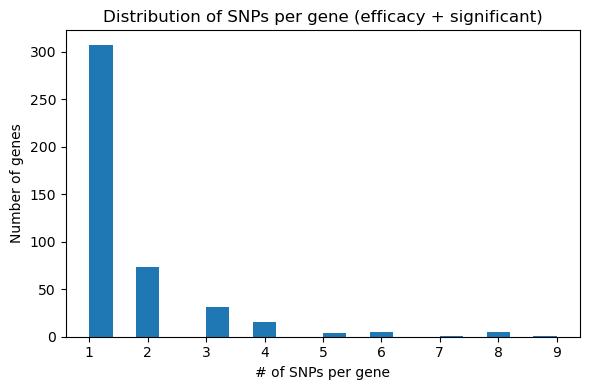

In [9]:
# Number of SNPs per gene
snps_per_gene = df_sig_eff.groupby("GENE_SYMBOL")["dbSNP_ID"].nunique()
plt.figure(figsize=(6,4))
plt.hist(snps_per_gene, bins=20)
plt.xlabel("# of SNPs per gene")
plt.ylabel("Number of genes")
plt.title("Distribution of SNPs per gene (efficacy + significant)")
plt.tight_layout()
plt.show()

### Question 6


*   **Question 6.1** Shuoyuan Gao Implementation for Question 6 is create package: [drug_response_23andme](https://github.com/GSYH/drug_response_23andme).

*   **Question 6.2** Erin Jenson's feature is code to answer the question: which drugs identified as significantly affected by gene variants in this person's genome are impacted by multiple gene variants? (see below)

*   **Question 6.3** Xiyan Zhou is implementing feature to answer the question: Which genes in this individual carry multiple significant pharmacogenomic variants that impact drug efficacy, making them potential “high-risk” genes for altered drug response?

Question 6.2

Biological question: which drugs identified as significantly affected by gene variants in this person's genome are impacted by multiple gene variants?

Drugs that have efficacy that is affected by many gene variants may be considered "complex pharmacogenomic drugs." Their dosing, effectiveness, and potential adverse reactions depend on a larger swath of genetic background, meaning genetic testing prior to administration may be necessary to ensure safety and efficacy. A well-characterized example is warfarin, where genetic variants in CYP2C9 and VKORC1 influence dosage.

AI disclaimer: chatGPT was used to generate code for this section, help troubleshoot code, and explain the code line-by-line.

If a row (gene variant) can map to multiple drugs, split it into multiple rows

In [10]:
#Create 'drug_list' column, and split multiple drug strings per row into a list using 'str.split'
df_sig_eff["drug_list"] = df_sig_eff["DRUG_NAME"].str.split(r"[,;/] ?")
#Expand data frame so that each drug in the list gets its own row using 'explode'
expanded = df_sig_eff.explode("drug_list")
#Clean up drug names for consistency: make them all lowercase and strip white space
expanded["drug_list"] = expanded["drug_list"].str.strip()
#Reset the index following explosion
expanded = expanded.reset_index(drop=True)
expanded

,dbSNP_ID,GENE_SYMBOL,DRUG_NAME,PMID,PHENOTYPE_CATEGORY,SIGNIFICANCE,NOTES,SENTENCE,ALLELE_PharmGKB,ALLELE_23andme,drug_list
0,rs163184,KCNQ1,sitagliptin,39792745,Efficacy,yes,"""KCNQ1 gene polymorphisms also significantly a...",Genotype GG is associated with decreased respo...,GG,T,sitagliptin
1,rs1799853,CYP2C9,sitagliptin,39792745,Efficacy,yes,"""CYP2C9 gene polymorphisms also significantly ...",Genotype TT is associated with decreased respo...,TT,C,sitagliptin
2,rs7903146,TCF7L2,exenatide,30700996,Efficacy,yes,"""After treatment with exenatide, only CT/TT in...",Genotypes CT + TT is associated with increased...,CT + TT,C,exenatide
3,rs8099917,IFNL3,"peginterferon alfa-2a, peginterferon alfa-2b, ...",26075078,Efficacy,yes,A multivariate logistic model showed that the ...,Genotype TT is associated with increased respo...,TT,T,peginterferon alfa-2a
4,rs8099917,IFNL3,"peginterferon alfa-2a, peginterferon alfa-2b, ...",26075078,Efficacy,yes,A multivariate logistic model showed that the ...,Genotype TT is associated with increased respo...,TT,T,peginterferon alfa-2b
...,...,...,...,...,...,...,...,...,...,...,...
2141,rs11549465,HIF1A,"cisplatin, gemcitabine, pemetrexed",40959922,Efficacy,yes,"""In heterozygotes with the HIF1A rs11549465 CT...",Genotype CT is associated with decreased respo...,CT,C,pemetrexed
2142,rs1042713,ADRB2,mepolizumab,40985517,Efficacy,yes,"""Our findings also suggest that this polymorph...",Allele G is associated with increased clinical...,G,G,mepolizumab
2143,rs11572080,CYP2C8,"corticosteroids, montelukast",38772712,Efficacy,yes,"Alleles complemented.""Mean asthma control scor...",Genotype CC is associated with increased clini...,CC,C,corticosteroids
2144,rs11572080,CYP2C8,"corticosteroids, montelukast",38772712,Efficacy,yes,"Alleles complemented.""Mean asthma control scor...",Genotype CC is associated with increased clini...,CC,C,montelukast


In [11]:
#Group all rows by drug name (groupby('drug_list') so that each group contains all SNP-annotation records for that
#drug. ['GENE_SYMBOL'].nunique() calculates the number of unique genes associated with each drug group. .reset_index()
#converts grouped dataframe back into a regular dataframe (not a grouped object).
multi_gene = expanded.groupby('drug_list')['GENE_SYMBOL'].nunique().reset_index()
#Rename the column that held the gene counts to 'num_genes' to clarify its meaning.
multi_gene = multi_gene.rename(columns={'GENE_SYMBOL': 'num_genes'})
#Sort the dataframe in descending order by number of genes associated
print(multi_gene.sort_values('num_genes', ascending=False).head(10))

                                             drug_list  num_genes
91                                           cisplatin         24
35   Tumor necrosis factor alpha (TNF-alpha) inhibi...         23
147                                       fluorouracil         23
225                                       methotrexate         22
137                                         etanercept         20
293                                        risperidone         19
65                                        atorvastatin         16
311                                        simvastatin         16
59                                      antipsychotics         16
186                                         infliximab         15


In [12]:
#Create new dataframe containing only drugs that are associated with more than one gene
multi_gene_drugs = multi_gene[multi_gene['num_genes'] > 1]
#Sort and print multi-gene drugs to inspect which drugs have multiple gene variatns
print("Drugs impacted by multiple genes:")
print(multi_gene_drugs.sort_values('num_genes', ascending=False))

Drugs impacted by multiple genes:
                                             drug_list  num_genes
91                                           cisplatin         24
35   Tumor necrosis factor alpha (TNF-alpha) inhibi...         23
147                                       fluorouracil         23
225                                       methotrexate         22
137                                         etanercept         20
..                                                 ...        ...
329                                         ticagrelor          2
324                                         telaprevir          2
347                                        varenicline          2
349                                          verapamil          2
353                               volatile anesthetics          2

[197 rows x 2 columns]


Make bar graph to show which drugs are affected by the most gene variants

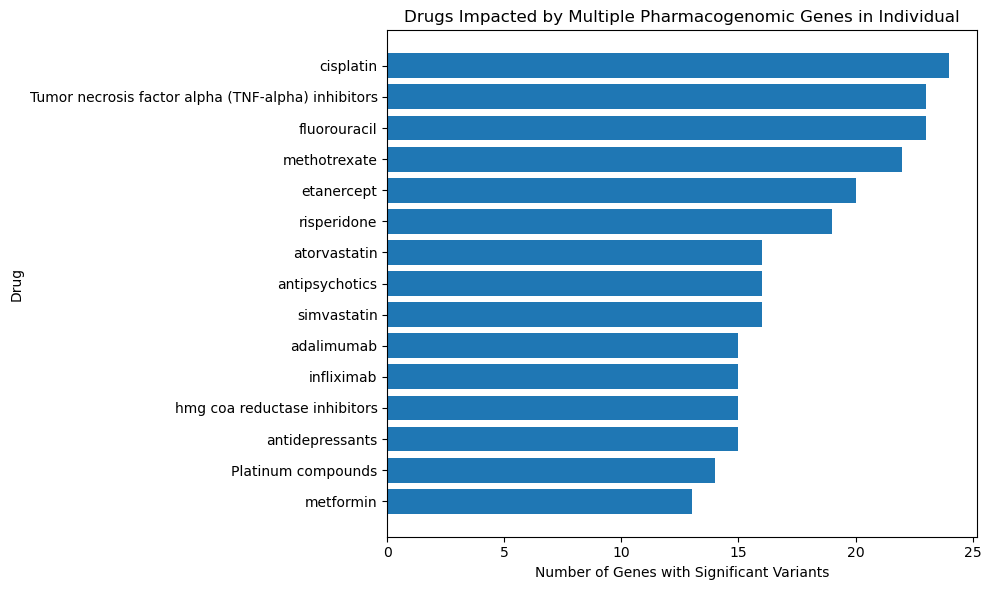

In [13]:
#Make figure that is 10 x 6 inches
plt.figure(figsize=(10,6))
#Prepare top 15 drugs that are ranked by multi-gene variant impact for plotting
top_n = multi_gene_drugs.sort_values('num_genes', ascending=False).head(15)
#Create horizontal bar graph (barh) with y-axis as drug name and bar length as number of unique genes affecting that
#drug's efficacy
plt.barh(top_n['drug_list'], top_n['num_genes'])
#Label x-axis
plt.xlabel('Number of Genes with Significant Variants')
#Label y-axis
plt.ylabel('Drug')
#Title plot
plt.title('Drugs Impacted by Multiple Pharmacogenomic Genes in Individual')
#Invert y-axis so drug with most genes is at the top (better for readability)
plt.gca().invert_yaxis()
#Adjust plot margins and spacing to keep labels visible
plt.tight_layout()
plt.show()

Prepare table for gene lists, can see which genes have drug efficacy-impacting variants for that drug

In [14]:
#Remove NaNs, convert to string if necessary
def safe_join(xs):
    xs_clean = [str(x) for x in xs if pd.notnull(x)]
    return ';'.join(xs_clean)

#Group SNP annotations by drug, collect all unique gene symbols into a list for each drug
gene_drug_map = expanded.groupby('drug_list')['GENE_SYMBOL'].unique().reset_index()

#For each drug's group of gene symbols, apply safe_join. Converts any missing value or non-string to a string,
#filters out NaN values, and joins them as a single string separated by ';'
gene_drug_map['GENE_SYMBOLS'] = gene_drug_map['GENE_SYMBOL'].apply(safe_join)
#Remove original column of gene lists and leaves just the drug name and joined string of gene symbols
gene_drug_map.drop('GENE_SYMBOL', axis=1, inplace=True)
#Show first few drugs and their associated gene symbols
print(gene_drug_map.head())

               drug_list                 GENE_SYMBOLS
0  "Beta blocking agents                       NEDD4L
1             "Thiazides                        PRKCA
2            "diuretics"                 PRKCA;NEDD4L
3  "hydrochlorothiazide"                        PRKCA
4    "interferon alfa-2a  IL18;IFNL3, IFNL4;IFNL3;FTO


Overall this analysis shows that drugs such as cisplatin, TNF-alpha inhibitors, fluorouracil, and methotrexate have efficacy that is affected by many gene variants in this individual. For other individuals who are prescribed these drugs, their specific gene variants may affect how well they respond to the drug. If this affect on efficacy is severe, genetic testing could be done prior to prescription to determine whether these drugs are likely to have a positive effect on an individual or not.

This analysis also allows us to see which genes have drug efficacy impacting variants for that drug. For example, variants in NEDD4L can cause changes in efficacy of beta blocking agents. For individuals that have done genetic testing and know they have variants in this gene, this analysis shows them that they may have an altered response to beta blockers.

6.3 (Xiyan Zhou). Question: Which genes in this individual carry multiple significant pharmacogenomic variants that impact drug efficacy, making them potential “high-risk” genes for altered drug response?

Many drugs are affected by genetic variants in the same gene. For example, CYP2D6 influences the metabolism of dozens of medications including antidepressants, opioids, and beta-blockers. If a person carries multiple significant variants in the same gene:
the overall impact on drug response may be stronger, the risk of unexpected treatment failure or side effects is higher, and these genes may warrant clinical attention when prescribing medications. 

In [26]:
#Count number of significant variants per gene
df_map = pd.read_csv("23andme_PharmGKB_map.tsv", sep="\t", dtype=str)
variant_counts = (
    df_map.groupby("GENE_SYMBOL")["dbSNP_ID"]
    .nunique()
    .reset_index()
    .rename(columns={"dbSNP_ID": "Num_Variants"})
)

variant_counts.sort_values("Num_Variants", ascending=False).head(10)


,GENE_SYMBOL,Num_Variants
433,VEGFA,9
152,DRD2,8
140,CYP3A4,8
224,IFNL3,8
345,RRM1,8
115,COMT,8
185,GALNT14,7
2,ABCC1,6
119,CRHR2,6
6,ABCG2,6


In [27]:
#Count number of drugs affected per gene
drug_counts = (
    df_map.groupby("GENE_SYMBOL")["DRUG_NAME"]
    .nunique()
    .reset_index()
    .rename(columns={"DRUG_NAME": "Num_Drugs"})
)

drug_counts.sort_values("Num_Drugs", ascending=False).head(10)


,GENE_SYMBOL,Num_Drugs
115,COMT,19
1,ABCB1,18
22,ADRB2,17
140,CYP3A4,17
225,"IFNL3, IFNL4",15
433,VEGFA,14
152,DRD2,14
377,SLCO1B1,13
57,BDNF,13
224,IFNL3,12


In [28]:
#Combine variant counts + drug counts
gene_summary = pd.merge(variant_counts, drug_counts, on="GENE_SYMBOL")
gene_summary = gene_summary.sort_values(
    ["Num_Variants", "Num_Drugs"], ascending=False
)

gene_summary.head(10)


,GENE_SYMBOL,Num_Variants,Num_Drugs
433,VEGFA,9,14
115,COMT,8,19
140,CYP3A4,8,17
152,DRD2,8,14
224,IFNL3,8,12
345,RRM1,8,4
185,GALNT14,7,3
57,BDNF,6,13
377,SLCO1B1,6,13
6,ABCG2,6,9


In [30]:
# Add the name of affected drugs
drug_list = (
    df_map.groupby("GENE_SYMBOL")["DRUG_NAME"]
    .apply(lambda x: ";".join(sorted(set(x))))
    .reset_index()
    .rename(columns={"DRUG_NAME": "Affected_Drugs"})
)

gene_summary = pd.merge(gene_summary, drug_list, on="GENE_SYMBOL")
gene_summary.head(10)
gene_summary.to_csv("Q6.3_high_risk_genes.tsv", sep="\t", index=False)


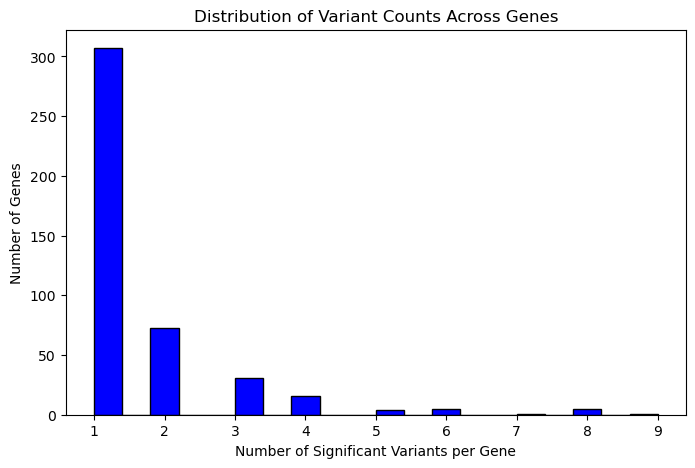

In [33]:
#Plot number of variant per gene
plt.figure(figsize=(8,5))
plt.hist(gene_summary["Num_Variants"], bins=20, color='blue', edgecolor='black')
plt.xlabel("Number of Significant Variants per Gene")
plt.ylabel("Number of Genes")
plt.title("Distribution of Variant Counts Across Genes")
plt.show()


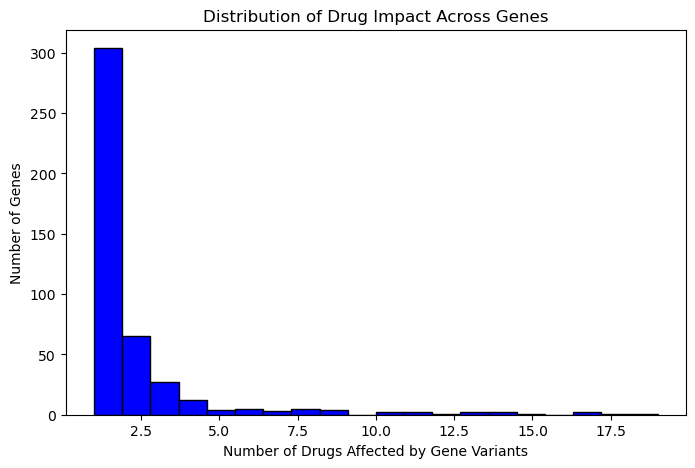

In [34]:
# Plot number of drugs affected per gene
plt.figure(figsize=(8,5))
plt.hist(gene_summary["Num_Drugs"], bins=20, color='blue', edgecolor='black')
plt.xlabel("Number of Drugs Affected by Gene Variants")
plt.ylabel("Number of Genes")
plt.title("Distribution of Drug Impact Across Genes")
plt.show()



In this extension, I implemented a feature to identify high-risk pharmacogenomic genes in an individual’s genome using 23andMe data and PharmGKB annotations. Starting from significant SNP–drug associations affecting drug efficacy, I merged the individual’s variants with curated PharmGKB information, filtered for significance, and summarized the data at the gene level. For each gene, I counted the number of impactful variants, the number of drugs affected, and aggregated a list of all associated drugs. The outputs include a detailed map table of variant–drug associations, a summary table of gene–drug pairs, and a ranked list of high-risk genes, along with visualizations showing the distribution of variants and drugs per gene. The summarization is saved to Q6.3_high_risk_genes.tsv

This analysis provides insight into which genes carry multiple variants that could influence the efficacy of various medications. By highlighting these high-risk pharmacogenes, the results can inform personalized medicine decisions, help prioritize genes for further biological investigation, and support risk assessment for drug response in clinical or research settings. It demonstrates how combining individual genomic data with curated pharmacogenomic knowledge can yield actionable insights into drug efficacy and variability in treatment outcomes.

AI disclaimer: AI is used in analyzing and selecting the feature I implement and have provided me sufficient relevant biological background knowledge, as well as generating code I don't know how to write and debugging. 